<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Treinamento_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports e definições de funções

In [1]:
# !pip install tensorflow
# !pip install keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import json
import sklearn
import numpy as np
import pandas as pd
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten, Dense, SpatialDropout1D, BatchNormalization
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam, Adadelta, SGD, RMSprop, Adagrad, Adamax, Nadam, Ftrl
from keras.models import Sequential
from keras.layers.embeddings import Embedding

from mlxtend.plotting import plot_confusion_matrix
from keras.callbacks import Callback, ModelCheckpoint, CSVLogger
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from keras.callbacks import EarlyStopping

In [4]:
def tokenize(tweets_list):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets_list)
    return tokenizer.texts_to_sequences(tweets_list), tokenizer

In [5]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            self.score = roc_auc_score(self.y_val, y_pred)
            self.false_positive_rate, self.true_positive_rate, _ = roc_curve(self.y_val, y_pred)          

# Carrega arquivo de saída (resultados)

In [6]:
# CONSTANTES DOS RESULTADOS
REDE = 'LSTM'

# BASE_NAME = 'BASE 0'
# BASE_NAME = 'BASE 1'
BASE_NAME = 'BASE 2'

# Caminho arquivo de saída
PATH_ARQ_SAIDA = "/content/drive/MyDrive/TCC/resultados/resultados.csv"

#  rede base otimizador acuracia val_loss learning_rate dropout batch_size roc_curve train_resume confusion_matrix
resultados = pd.read_csv(PATH_ARQ_SAIDA, index_col=0)
resultados.head()

,rede,base,otimizador,acuracia,val_loss,learning_rate,dropout,batch_size,roc_curve,train_resume,confusion_matrix,epochs,rank
0,Bi-LSTM,BASE 0,Nadam,0.864151,0.359641,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 855, ""01"": 73, ""10"": 179, ""11"": 748}",4,2.402818
1,Bi-LSTM,BASE 0,Nadam,0.876550,0.302028,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 803, ""01"": 125, ""10"": 104, ""11"": 823}",4,2.902218
2,Bi-LSTM,BASE 0,Nadam,0.864151,0.318839,0.0001,0.3,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 802, ""01"": 126, ""10"": 126, ""11"": 801}",4,2.710301
3,Bi-LSTM,BASE 0,RMSProp,0.852291,0.325597,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 800, ""01"": 128, ""10"": 146, ""11"": 781}",4,2.617622
4,Bi-LSTM,BASE 0,RMSProp,0.852291,0.327882,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3}, ""a...","{""00"": 838, ""01"": 90, ""10"": 184, ""11"": 743}",4,2.599382


# Carrega base

In [7]:
if BASE_NAME == 'BASE 0':
  # PATH_BASE0_NAO_PROCESSADA  -Base0 Bruta Não processada
  PATH_BASE = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base0_classificada_balanceada.csv"

if BASE_NAME == 'BASE 1':
  # PATH_BASE1_JUNTO_COM_DA_LEILA_BALANCEADA - Base1 Com StopWords
  PATH_BASE = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1JuntaHateENotHateDaLeila_balanceada.csv"

if BASE_NAME == 'BASE 2':
  # PATH_BASE2_LEILA_LIMPISSIMA_BALANCEADA - Base2 Sem StopWords
  PATH_BASE = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_maior4_menor25_limpissima_balanceada.csv"

In [8]:
# # Base0 Bruta Não processada
# PATH_BASE_1_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1_classificada_balanceada.csv"
# #Base0 Bruta Não processada
# PATH_BASE_2_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_classificada_balanceada.csv"
# #MATRIZ_CBOW_300_BASE_1 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base1JuntaHateENotHateDaLeila_balanceada_CBOW300.CSV", delimiter=',')
# #MATRIZ_CBOW_300_BASE_2_LEILA = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_maior4_menor25_limpissima_balanceada_CBOW300.CSV", delimiter=',')
# #MATRIZ_CBOW_300_BASE_2 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_classificada_balanceada_CBOW300.csv", delimiter=',') #saida

In [9]:
tweets = pd.read_csv(PATH_BASE, index_col=0)
tweets

,label,text
0,1,ambiguinho eu estou com nojo
1,1,menino do céu para que está feio
2,1,já pergunto a porra do trem já sabendo da vdd ...
3,1,sardella só faz merda
4,1,foda se na real vou tratar igual
...,...,...
4881,0,estou sem presidente por quatro anos nãomerepr...
4882,0,somos todos iguais braços dados ou não quem sa...
4883,0,que deus nos proteja e cuidem um do outro somo...
4884,0,quem será que não sabe votar


In [10]:
# Pega a quantidade de palavras únicas dos tweets de toda a base
_, text_tokenizer = tokenize(tweets['text'])
text_vocab_size = len(text_tokenizer.word_index)
print("Vocabulary size:", text_vocab_size)

Vocabulary size: 9147


# Prepara os dados de train, test e validation da base

In [11]:
NUM_BASES = 4
# Carrega os paths das divisões das bases
LIST_PATH_TRAIN = []
LIST_PATH_TEST = []
LIST_PATH_VAL = []
for i in range(NUM_BASES):
  LIST_PATH_TRAIN.append('/content/drive/MyDrive/TCC/dados/processadas/bases_balanceadas_divididas/train'+str(i)+'.csv')
  LIST_PATH_TEST.append('/content/drive/MyDrive/TCC/dados/processadas/bases_balanceadas_divididas/test'+str(i)+'.csv')
  LIST_PATH_VAL.append('/content/drive/MyDrive/TCC/dados/processadas/bases_balanceadas_divididas/val'+str(i)+'.csv')

In [12]:
# 0 - Base0 bruta não processada
# 1 - Base1 Com StopWords
# 2 - Base2 Sem StopWords
# 3 - Base2 Nossa sem stopwords
base_index = int(BASE_NAME.split()[1])
base_train = pd.read_csv(LIST_PATH_TRAIN[base_index], index_col=0)
base_test = pd.read_csv(LIST_PATH_TEST[base_index], index_col=0)
base_val = pd.read_csv(LIST_PATH_VAL[base_index], index_col=0)

In [13]:
# Dados train
Y_TRAIN = base_train['label']
base_train.drop(['label'], axis='columns', inplace=True)
X_TRAIN = base_train.to_numpy()

# Dados test
Y_TEST = base_test['label']
base_test.drop(['label'], axis='columns', inplace=True)
X_TEST = base_test.to_numpy()

# Dados validation
Y_VAL = base_val['label']
base_val.drop(['label'], axis='columns', inplace=True)
X_VAL = base_val.to_numpy()

max_text_length = X_TRAIN.shape[1]

print(X_TRAIN.shape)
print(X_TEST.shape)
print(X_VAL.shape)

(2930, 24)
(978, 24)
(978, 24)


# Execução modelo

In [14]:
# parametros tunning:
BATCH_SIZE = [32, 64]
LEARN_RATE = [0.0001, 0.001]
OTMIZADORES = ['Nadam', 'RMSProp', 'SGD']
DROPOUT = [0.1, 0.2, 0.3]

# parametros estaticos:
EPOCHS = 10
EMBEDDING_DIMENSION = 300  
MAX_TEXT_SIZE = max_text_length 
VOCAB_SIZE = text_vocab_size

In [15]:
def optimize (optimize, learning_rate):
  if optimize == 'Nadam':
    return Nadam(learning_rate=learning_rate, name="Nadam")
  
  if optimize == 'RMSProp':
    return RMSprop(learning_rate=learning_rate, name="RMSprop")
  
  if optimize == 'SGD':
    return SGD(learning_rate=learning_rate, name="SGD")

In [16]:
def create_lstm (vocab_size, embedding_dimen, max_text_size, dropout_rate ):

  modelo = keras.Sequential([
    keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIMENSION, input_length=max_text_size),
    # keras.layers.Embedding(input_dim=MATRIZ_CBOW_300_BASE_2.shape[0],
                            # output_dim=MATRIZ_CBOW_300_BASE_2.shape[1],
                            # weights=[MATRIZ_CBOW_300_BASE_2],
                            # embeddings_initializer=keras.initializers.Constant(MATRIZ_CBOW_300_BASE_2),
                            # input_length=max_text_size,
                            # trainable=True),
    keras.layers.LSTM(max_text_size, dropout=dropout_rate, name="LSTM"),
    keras.layers.Dense(1, activation='sigmoid')
    ])

  return modelo  

In [17]:
def train_model(embedding_dimen, batch_size, epochs, learning_rate, optimizer, dropout_rate):
    opt = optimize(optimizer, learning_rate)
    
    model = create_lstm(VOCAB_SIZE, EMBEDDING_DIMENSION, MAX_TEXT_SIZE, dropout_rate)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=opt, metrics=['accuracy'])        
    
    ra_val = RocAucEvaluation(validation_data=(X_VAL, Y_VAL), interval = 1)
    
    csv_logger = CSVLogger('log.csv', append=False, separator=';')

    early_stop = EarlyStopping(monitor = "val_loss", mode = "min", verbose = 0, patience = 1)                                                                                       
   
    history = model.fit(X_TRAIN, Y_TRAIN, batch_size=batch_size, epochs=epochs, validation_data=(X_VAL, Y_VAL), verbose=0, use_multiprocessing=True,  callbacks = [ra_val, csv_logger, early_stop])
    
    scores = model.evaluate(X_TEST, Y_TEST, verbose=0)
    
    return history, model, ra_val, scores, csv_logger

In [18]:
# history, model1, ra_val, scores, csv_logger = train_model(EMBEDDING_DIMENSION, 32, 10, 0.2, 0.001, 'Nadam', 0.2)

In [19]:
# my_log = pd.read_csv('log.csv',sep=';')
# my_log

In [20]:
# plot dos gráficos
count = 1
for BS in BATCH_SIZE:
  for LR in LEARN_RATE:
    for OT in OTMIZADORES:
      for DO in DROPOUT:
        print("Iteração "+str(count))
        count+=1
        
        history, model1, ra_val, scores, csv_logger = train_model(EMBEDDING_DIMENSION, BS, EPOCHS, LR, OT, DO)

        #
        y_predito = model1.predict(X_TEST).round()
        y_gabarito = Y_TEST
        
        # Parâmetros
        # rede base otimizador acuracia val_loss learning_rate dropout batch_size roc_curve train_resume confusion_matrix
        NOME_REDE = REDE
        NOME_BASE = BASE_NAME
        NOME_OTIMIZADOR = OT
        ACURACIA = scores[1]
        LOSS = scores[0] 
        LEARNING_RATE = LR
        DROPOUT_RATE = DO
        BATCH = BS
        ROC_CURVE = json.dumps({
            "false_positive_rate": list(ra_val.false_positive_rate),
            "true_positive_rate": list(ra_val.true_positive_rate),
            "score": ra_val.score})
        TRAIN_RESUME = json.dumps(pd.read_csv('log.csv',sep=';').to_dict()) 
        
        confusion = confusion_matrix(y_gabarito, y_predito)
        CONFUSION_MATRIX = json.dumps({
            "00": int(confusion[0][0]),
            "01": int(confusion[0][1]),
            "10": int(confusion[1][0]),
            "11": int(confusion[1][1])
        })

        EPOCHS = len(history.history['val_loss'])
        RANK = ACURACIA/LOSS
 
        # Salvando resultado do modelo
        registro_resultado = {resultados.columns[0]: NOME_REDE, 
                              resultados.columns[1]: NOME_BASE, 
                              resultados.columns[2]: NOME_OTIMIZADOR,
                              resultados.columns[3]: ACURACIA, 
                              resultados.columns[4]: LOSS,
                              resultados.columns[5]: LEARNING_RATE,
                              resultados.columns[6]: DROPOUT_RATE,
                              resultados.columns[7]: BATCH,
                              resultados.columns[8]: ROC_CURVE,
                              resultados.columns[9]: TRAIN_RESUME,
                              resultados.columns[10]: CONFUSION_MATRIX,
                              resultados.columns[11]: EPOCHS,
                              resultados.columns[12]: RANK,
                            }

        resultados = resultados.append(registro_resultado, ignore_index=True)

Iteração 1
Iteração 2
Iteração 3
Iteração 4
Iteração 5
Iteração 6
Iteração 7
Iteração 8
Iteração 9
Iteração 10
Iteração 11
Iteração 12
Iteração 13
Iteração 14
Iteração 15
Iteração 16
Iteração 17
Iteração 18
Iteração 19
Iteração 20
Iteração 21
Iteração 22
Iteração 23
Iteração 24
Iteração 25
Iteração 26
Iteração 27
Iteração 28
Iteração 29
Iteração 30
Iteração 31
Iteração 32
Iteração 33
Iteração 34
Iteração 35
Iteração 36


In [21]:
resultados.tail()

,rede,base,otimizador,acuracia,val_loss,learning_rate,dropout,batch_size,roc_curve,train_resume,confusion_matrix,epochs,rank
211,LSTM,BASE 2,RMSProp,0.900818,0.265472,0.001,0.2,64,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1}, ""accuracy"": {""0"": ...","{""00"": 406, ""01"": 83, ""10"": 14, ""11"": 475}",2,3.393269
212,LSTM,BASE 2,RMSProp,0.888548,0.327523,0.001,0.3,64,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1}, ""accuracy"": {""0"": ...","{""00"": 399, ""01"": 90, ""10"": 19, ""11"": 470}",2,2.712934
213,LSTM,BASE 2,SGD,0.493865,0.693313,0.001,0.1,64,"{""false_positive_rate"": [0.0, 0.00204498977505...","{""epoch"": {""0"": 0, ""1"": 1}, ""accuracy"": {""0"": ...","{""00"": 483, ""01"": 6, ""10"": 489, ""11"": 0}",2,0.712326
214,LSTM,BASE 2,SGD,0.507157,0.693249,0.001,0.2,64,"{""false_positive_rate"": [0.0, 0.00204498977505...","{""epoch"": {""0"": 0, ""1"": 1}, ""accuracy"": {""0"": ...","{""00"": 7, ""01"": 482, ""10"": 0, ""11"": 489}",2,0.731566
215,LSTM,BASE 2,SGD,0.495910,0.693094,0.001,0.3,64,"{""false_positive_rate"": [0.0, 0.00204498977505...","{""epoch"": {""0"": 0, ""1"": 1}, ""accuracy"": {""0"": ...","{""00"": 485, ""01"": 4, ""10"": 489, ""11"": 0}",2,0.715502


In [22]:
resultados.tail(36)

,rede,base,otimizador,acuracia,val_loss,learning_rate,dropout,batch_size,roc_curve,train_resume,confusion_matrix,epochs,rank
180,LSTM,BASE 2,Nadam,0.931493,0.227112,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 473, ""01"": 16, ""10"": 51, ""11"": 438}",7,4.101471
181,LSTM,BASE 2,Nadam,0.928425,0.219987,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 469, ""01"": 20, ""10"": 50, ""11"": 439}",7,4.220357
182,LSTM,BASE 2,Nadam,0.929448,0.237719,0.0001,0.3,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 461, ""01"": 28, ""10"": 41, ""11"": 448}",7,3.909865
183,LSTM,BASE 2,RMSProp,0.915133,0.238239,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 465, ""01"": 24, ""10"": 59, ""11"": 430}",7,3.841233
184,LSTM,BASE 2,RMSProp,0.915133,0.241674,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 456, ""01"": 33, ""10"": 50, ""11"": 439}",7,3.786637
185,LSTM,BASE 2,RMSProp,0.900818,0.281624,0.0001,0.3,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 457, ""01"": 32, ""10"": 65, ""11"": 424}",7,3.198652
186,LSTM,BASE 2,SGD,0.501023,0.693492,0.0001,0.1,32,"{""false_positive_rate"": [0.0, 0.00204498977505...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 1, ""01"": 488, ""10"": 0, ""11"": 489}",7,0.722463
187,LSTM,BASE 2,SGD,0.497955,0.694687,0.0001,0.2,32,"{""false_positive_rate"": [0.0, 0.00204498977505...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 487, ""01"": 2, ""10"": 489, ""11"": 0}",7,0.716805
188,LSTM,BASE 2,SGD,0.560327,0.692350,0.0001,0.3,32,"{""false_positive_rate"": [0.0, 0.00204498977505...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2, ""3"": 3, ""4""...","{""00"": 403, ""01"": 86, ""10"": 344, ""11"": 145}",7,0.809313
189,LSTM,BASE 2,Nadam,0.952965,0.167077,0.0010,0.1,32,"{""false_positive_rate"": [0.0, 0.0, 0.0, 0.0, 0...","{""epoch"": {""0"": 0, ""1"": 1, ""2"": 2}, ""accuracy""...","{""00"": 474, ""01"": 15, ""10"": 31, ""11"": 458}",3,5.703736


In [23]:
# Caso queira deletar uma linha use o código abaixo
# Use a propriedade label para especificar o índice da linha
#resultados = resultados.drop(labels=1, axis=0)
#resultados = resultados.reset_index(drop=True)
#resultados

In [24]:
# Salva arquivo de saída
resultados.to_csv(PATH_ARQ_SAIDA)

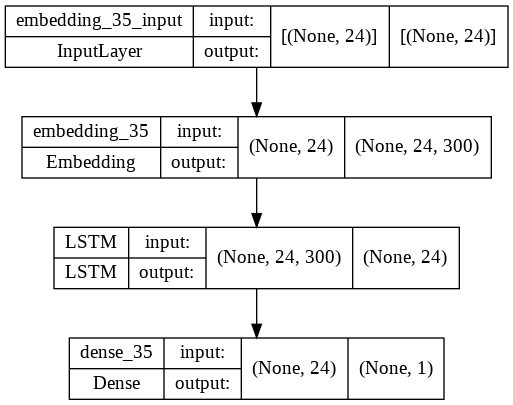

In [25]:
tf.keras.utils.plot_model(model1, to_file='/meuarquivo.png', show_shapes=True)